In [1]:
import cooltools
import bioframe
import cooler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os, subprocess
import scipy
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
from itertools import combinations
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-poster')
from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.1'):
    raise AssertionError("tutorials rely on cooltools version 0.5.1 or higher,"+
                         "please check your cooltools version and update to the latest")

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

import cooltools.lib.plotting
from matplotlib.colors import LogNorm

In [2]:
path = "/home/sgaudin/my_coolers/proper_coolers/balanced_merged_cool/manuscript_mustache/"
name_list = [ 'Rad21KO', 'WT' , 'WaplcKO_merge', 'tetoWAPL']

In [3]:
df= {}
for i, n in enumerate(name_list):
    df[n] = pd.read_csv(f'{path}{n}.tsv', sep='\t')
    df[n]['mid1'] = (df[n].BIN1_START + df[n].BIN1_END)/2
    df[n]['mid2'] = (df[n].BIN2_START + df[n].BIN2_END)/2
    df[n]['sep'] = np.abs(df[n].mid1 - df[n].mid2)//1000 
    df[n] = df[n][df[n].FDR <= 0.05]

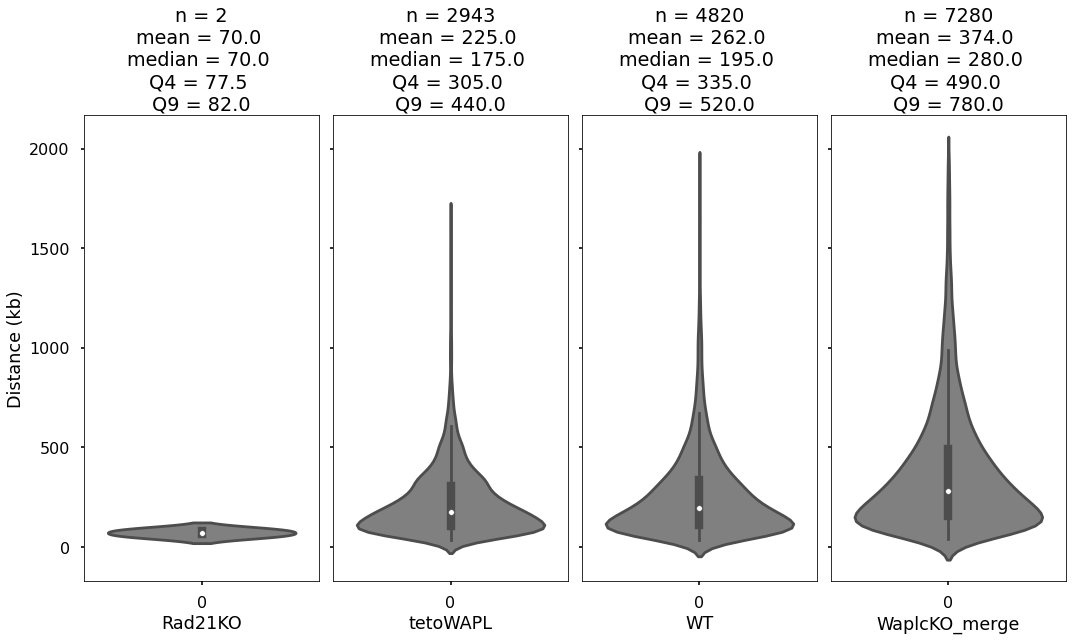

In [4]:
f, axs = plt.subplots(1, 4, figsize=(15, 9), sharey=True)
for i, n in enumerate(['Rad21KO', 'tetoWAPL', 'WT', 'WaplcKO_merge']): 
    ax = axs[i]
    sns.violinplot(data=df[n].sep, ax=ax, notch=False, color='grey') 
    ax.set_xlabel(n)
    ax.set_title(f'n = {len(df[n])}\nmean = {np.round(df[n].sep.mean())} \nmedian = {np.round(df[n].sep.median())} \nQ4 = {np.quantile(df[n].sep, 0.75)} \nQ9 = {np.quantile(df[n].sep, 0.9)}')
axs[0].set_ylabel('Distance (kb)')
plt.tight_layout()

In [5]:
data = pd.DataFrame()
for n in ['WaplcKO_merge', 'WT', 'tetoWAPL', 'Rad21KO']:
    data[n] = df[n].sep
data = data.rename(columns={"WaplcKO_merge":"WAPLcKO"})

In [7]:
sns.set_palette(['steelblue', 'darkgreen', 'grey', 'darkseagreen'])

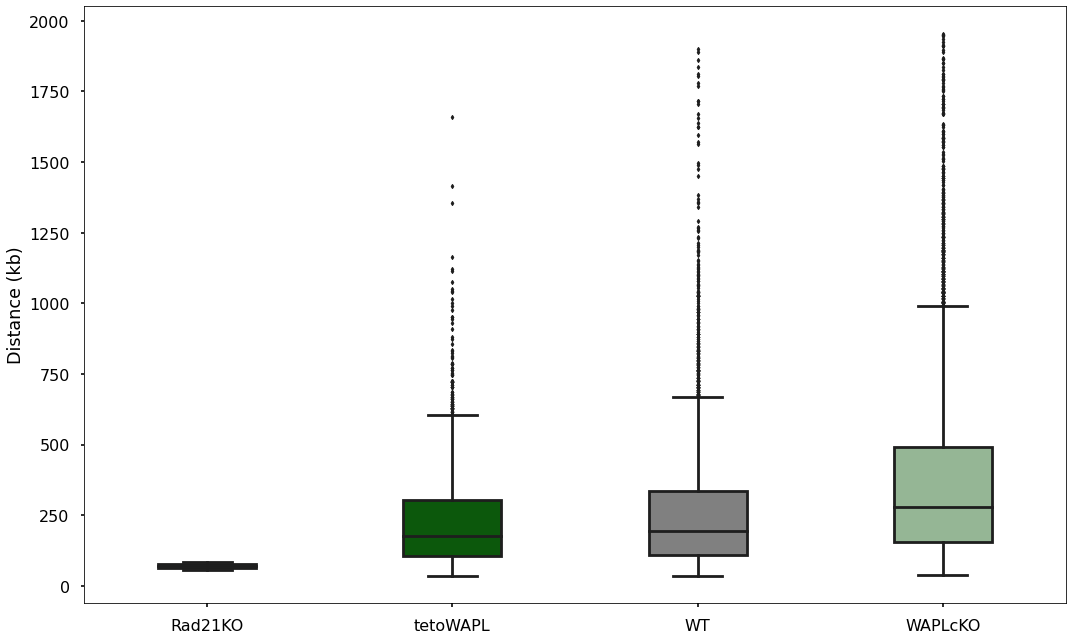

In [8]:
plt.figure(figsize=(15, 9))
sns.boxplot(data=data[['Rad21KO', 'tetoWAPL', 'WT', 'WAPLcKO' ]],  width=0.4, fliersize=3) 
plt.ylabel('Distance (kb)')
plt.tight_layout()

In [9]:
flierprops = dict(marker='.', markerfacecolor='None', markersize=3,  markeredgecolor='black')

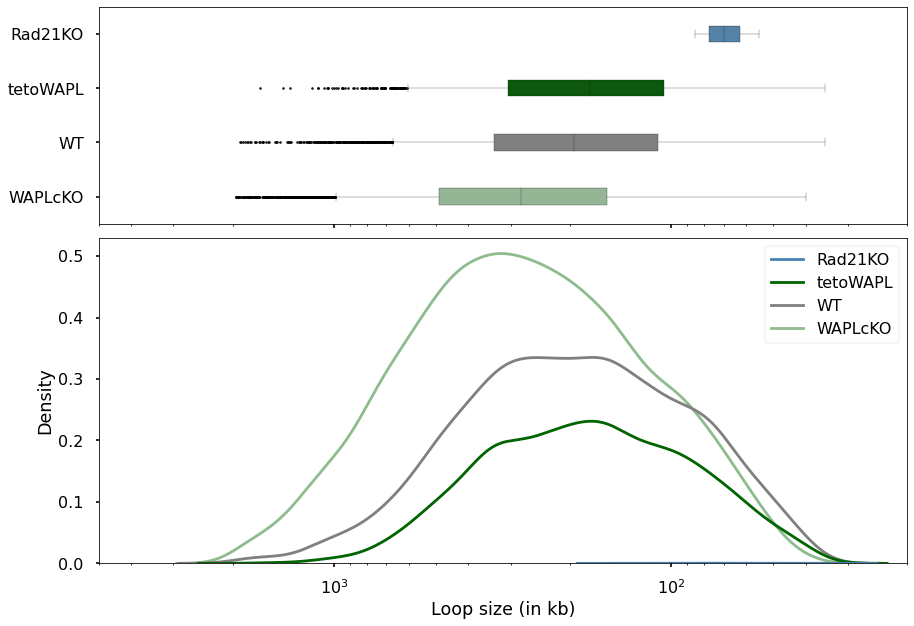

In [10]:
f, (ax_box, ax_kde) = plt.subplots(2, sharex=True, gridspec_kw = {"height_ratios": (.4, .6)})
#plt.figure(figsize=(12, 6))
#sns.swarmplot(data=data[['Rad21KO',  'tetoWAPL', 'WT', 'WAPLcKO' ]], ax=ax_box, orient='h', alpha=0.5) 
sns.boxplot(data=(data[['Rad21KO',  'tetoWAPL', 'WT', 'WAPLcKO' ]]), ax=ax_box, fliersize = 1.5, width=0.3, linewidth=0.3, orient='h', showfliers= True, flierprops = flierprops) 
plt.xscale('log')

sns.kdeplot(data=data[['Rad21KO',  'tetoWAPL', 'WT', 'WAPLcKO' ]], log_scale=True, ax=ax_kde, color='white') 
plt.ylabel('Density')
plt.xlabel('Loop size (in kb)')
plt.xlim(5e3, 2e1)
plt.tight_layout()

In [11]:
x = data.WT.dropna()
for n in ['Rad21KO', 'tetoWAPL', 'WAPLcKO']:
    y = data[n].dropna()
    print(n, scipy.stats.ranksums(x, y).pvalue, scipy.stats.mannwhitneyu(x, y).pvalue)

Rad21KO 0.05089336738341446 0.05090353245681608
tetoWAPL 1.8305109847982008e-06 1.8265737053217116e-06
WAPLcKO 5.021404410866718e-111 4.895167751825035e-111
